# Lab 1: Breast cancer classification

In this lab you will implement and train a single‑layer neural network model (affine + sigmoid) from scratch using NumPy to perform binary classification on the Breast Cancer Wisconsin dataset.

## Learning objectives
- Understand and implement the forward pass of a logistic model with the sigmoid activation.
- Derive and implement binary cross‑entropy (BCE) loss and its gradient.
- Train with mini‑batch SGD and monitor loss/accuracy.
- Evaluate on a held‑out test set and interpret results.

## What you'll do
1. Load and standardize the dataset.
2. Review `forward`, `bce_loss`, and `backward`.
3. Train with stochastic gradient descent.
4. Plot loss curves and report accuracy.
5. Visualize decision boundary


Go through the code example and complete the exercises at the bottom.



### Data loading and preprocessing
We load the Breast Cancer Wisconsin dataset with `sklearn`, split into train and test sets with stratification to preserve class balance, and standardize features using only the training statistics (mean and std). Standardization centers the features to zero mean and unit variance, which stabilizes the optimization of our logistic model.


In [1]:
# Imports and data
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Load
bunch = load_breast_cancer(as_frame=True)
df = bunch.frame.copy()
feature_names = bunch.feature_names.tolist()
X = df[feature_names].to_numpy(dtype=np.float64)
y = df["target"].to_numpy(dtype=np.float64).reshape(-1, 1)  # (N,1)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize using train stats only
mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

N, D = X_train.shape
print(f"Train N={N}, D={D}; Test N={X_test.shape[0]}")

Train N=455, D=30; Test N=114


In [2]:
from collections import Counter
print("Train distribution:", Counter(y_train.flatten()))
print("Test distribution:", Counter(y_test.flatten()))


Train distribution: Counter({1.0: 285, 0.0: 170})
Test distribution: Counter({1.0: 72, 0.0: 42})


### Model: one-layer neural network (logistic regression)
We implement a single affine layer followed by a sigmoid activation: `y_hat = σ(XW + b)`, where `W∈R^{D×1}` and `b∈R`.
- Forward: computes logits `z = XW + b` and probabilities `y_hat = σ(z)`.
- Loss: binary cross-entropy (BCE), averaged over the batch.
- Backward: with sigmoid+BCE, the gradient w.r.t. logits is `dz = (y_hat - y) / N`, then `dW = X^T dz`, `db = sum(dz)`.
We also report accuracy by thresholding probabilities at 0.5.


#### Parameters of the network and activation (mathematical notation)

- **Weights:** $W \in \mathbb{R}^{D \times 1}$ (one parameter per input feature).
- **Bias:** $b \in \mathbb{R}$ (a scalar shared across examples).
- **Total trainable parameters:** $D + 1$.

Given standardized inputs $X \in \mathbb{R}^{N \times D}$, the model computes logits and probabilities as

$$
z = XW + b \in \mathbb{R}^{N \times 1}, \qquad \hat{y} = \sigma(z) \in (0,1)^{N \times 1}.
$$

#### Sigmoid definition and gradient

$$
\sigma(z) = \frac{1}{1 + e^{-z}} , \qquad \frac{\mathrm{d}\,\sigma}{\mathrm{d}z} = \sigma(z)\bigl(1 - \sigma(z)\bigr).
$$

With binary cross-entropy (BCE) loss and a batch of size $N$, the gradients simplify to

$$
\mathrm{d}z = \frac{\hat{y} - y}{N}, \qquad \mathrm{d}W = X^\top \mathrm{d}z, \qquad \mathrm{d}b = \mathbf{1}^\top \mathrm{d}z.
$$


In [3]:
# One-layer NN (logistic regression) - NumPy

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Initialize parameters
rng = np.random.default_rng(42)
W = rng.normal(0.0, 0.01, size=(D, 1))
b = np.zeros((1,), dtype=np.float64)

# Forward

def forward(X):
    z = X @ W + b  # (N,1)
    y_hat = sigmoid(z)
    cache = {"X": X, "z": z, "y_hat": y_hat}
    return y_hat, cache

# Binary cross-entropy loss

def bce_loss(y_hat, y_true):
    eps = 1e-8
    y_hat = np.clip(y_hat, eps, 1 - eps)
    loss = -np.mean(y_true * np.log(y_hat) + (1 - y_true) * np.log(1 - y_hat))
    return loss

# Backward

def backward(cache, y_true):
    X = cache["X"]
    y_hat = cache["y_hat"]
    N = X.shape[0]
    dz = (y_hat - y_true) / N  # dL/dz for sigmoid+bce
    dW = X.T @ dz  # (D,1)
    db = dz.sum(axis=0)  # (1,)
    return dW, db

# Accuracy

def accuracy(y_hat, y_true, threshold=0.5):
    preds = (y_hat >= threshold).astype(np.float64)
    return float(np.mean(preds == y_true))

print("Initialized one-layer NN parameters.")


Initialized one-layer NN parameters.


### Training: mini-batch SGD loop
At each epoch we shuffle the training data, iterate mini-batches, and perform:
1) forward pass to get `y_hat`, 2) compute BCE loss, 3) backprop to get `dW` and `db`, 4) parameter update with learning rate `lr`.
We also track train/test loss (and accuracy) per epoch to monitor convergence and generalization.

In [4]:
# Training loop (SGD)
lr = 0.001
num_epochs = 200
batch_size = 64

N_train = X_train.shape[0]
indices = np.arange(N_train)

# Track loss per epoch
train_losses = []
test_losses = []

for epoch in range(1, num_epochs + 1):
    # Shuffle
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    # Mini-batches
    for start in range(0, N_train, batch_size):
        end = start + batch_size
        Xb = X_train[start:end]
        yb = y_train[start:end]
        # Forward
        y_hat, cache = forward(Xb)
        # Loss
        loss = bce_loss(y_hat, yb)
        # Backward
        dW, db_ = backward(cache, yb)
        # Update
        W -= lr * dW
        b -= lr * db_

    # Evaluate full-batch train/test loss each epoch
    train_pred, _ = forward(X_train)
    test_pred, _ = forward(X_test)
    train_loss = bce_loss(train_pred, y_train)
    test_loss = bce_loss(test_pred, y_test)
    train_losses.append(float(train_loss))
    test_losses.append(float(test_loss))

    if epoch % 20 == 0 or epoch == 1:
        # Accuracy
        train_acc = accuracy(train_pred, y_train)
        test_acc = accuracy(test_pred, y_test)
        print(f"Epoch {epoch:03d} | loss={train_loss:.4f} | train_acc={train_acc:.3f} | test_acc={test_acc:.3f}")


Epoch 001 | loss=0.6819 | train_acc=0.705 | test_acc=0.596
Epoch 020 | loss=0.4853 | train_acc=0.934 | test_acc=0.886
Epoch 040 | loss=0.3890 | train_acc=0.943 | test_acc=0.904
Epoch 060 | loss=0.3334 | train_acc=0.945 | test_acc=0.912
Epoch 080 | loss=0.2971 | train_acc=0.954 | test_acc=0.939
Epoch 100 | loss=0.2707 | train_acc=0.954 | test_acc=0.947
Epoch 120 | loss=0.2506 | train_acc=0.956 | test_acc=0.947
Epoch 140 | loss=0.2346 | train_acc=0.958 | test_acc=0.947
Epoch 160 | loss=0.2215 | train_acc=0.958 | test_acc=0.947
Epoch 180 | loss=0.2105 | train_acc=0.960 | test_acc=0.947
Epoch 200 | loss=0.2012 | train_acc=0.963 | test_acc=0.947


In [11]:
# Final evaluation
with np.errstate(over='ignore'):
    y_test_pred, _ = forward(X_test)

acc = accuracy(y_test_pred, y_test)
print({"test_accuracy": float(acc)})


{'test_accuracy': 0.9473684210526315}


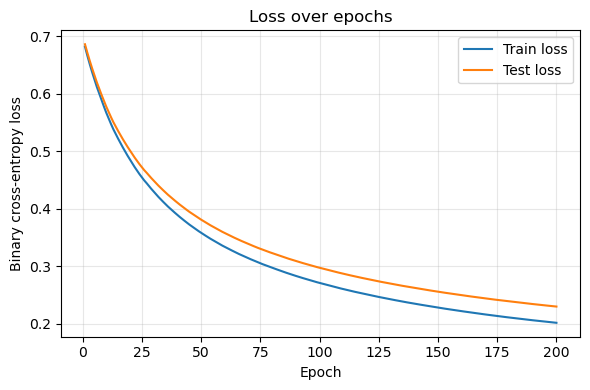

In [6]:
# Plot training and test loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train loss")
plt.plot(range(1, len(test_losses)+1), test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy loss")
plt.title("Loss over epochs")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Decision boundary in 2D (two features)
To visualize the learned logistic regression classifier, we can plot its decision boundary over two selected standardized features. Since the model is linear in the full 30-D space, the boundary is a hyperplane. When we restrict to two features and hold all other features fixed at their standardized mean (0), this induces a straight line in the 2D plane. We will:

- Choose two feature indices (by default the first two columns in `feature_names`).
- Create a grid over the range of those two standardized features observed in the training set.
- For each grid point, form a full 30-D standardized vector by setting the two chosen features to the grid coordinates and the remaining features to 0, then compute `p(y=1|x)` with our trained model.
- Plot the decision regions (`p>=0.5` vs `<0.5`) and overlay the training points colored by class.

Tip: You can change `i_feat` and `j_feat` to visualize other pairs of features.


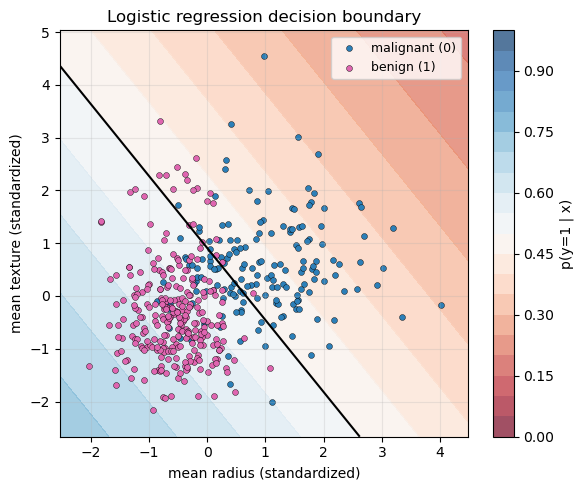

In [10]:
# 2D decision boundary visualization for two features
import numpy as np
import matplotlib.pyplot as plt

# Choose two features to visualize (indices in standardized X)
i_feat = 0  # default: first feature
j_feat = 1  # default: second feature

feat_i_name = feature_names[i_feat]
feat_j_name = feature_names[j_feat]

# Ranges from training data (already standardized)
x_i = X_train[:, i_feat]
x_j = X_train[:, j_feat]
margin = 0.5
x_min, x_max = x_i.min() - margin, x_i.max() + margin
y_min, y_max = x_j.min() - margin, x_j.max() + margin

# Meshgrid
h = 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Build full D-dim standardized inputs for grid, fixing other features at 0
num_points = xx.size
X_grid = np.zeros((num_points, D), dtype=np.float64)
X_grid[:, i_feat] = xx.ravel()
X_grid[:, j_feat] = yy.ravel()

# Predict probabilities with trained model
probs, _ = forward(X_grid)
Z = probs.reshape(xx.shape)

# Plot decision regions and training points
plt.figure(figsize=(6,5))
cs = plt.contourf(xx, yy, Z, levels=np.linspace(0, 1, 21), cmap="RdBu", alpha=0.7)
plt.colorbar(cs, label="p(y=1 | x)")

# Decision boundary p=0.5 line
plt.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=1.5)

# Overlay training points
y_train_flat = y_train.reshape(-1)
plt.scatter(x_i[y_train_flat==0], x_j[y_train_flat==0], s=18, c="#2c7fb8", edgecolor="k", linewidth=0.3, label="malignant (0)")
plt.scatter(x_i[y_train_flat==1], x_j[y_train_flat==1], s=18, c="#df65b0", edgecolor="k", linewidth=0.3, label="benign (1)")

plt.xlabel(f"{feat_i_name} (standardized)")
plt.ylabel(f"{feat_j_name} (standardized)")
plt.title("Logistic regression decision boundary")
plt.legend(frameon=True, fontsize=9)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

## Exercises

* Analyze the decision boundary above for several pairs of features
* Try to find features that seems to be easy to discriminate between the classes for
* Retrain the model with only these two features
* Report accuracy and plot the new decision boundary



## 1. Split & standardization
- Validation set from the training data
- It takes the existing training set and splits it 80/20 (stratified), for select feature pairs and tune choices without touching the test set.
- Standardizing features (train-only mean/std) improves conditioning so gradient steps are comparable across dimensions, which speeds and stabilizes SGD.


In [14]:
from sklearn.preprocessing import StandardScaler
scaler_in = StandardScaler().fit(X_tr)   # fit on X_tr only
X_tr = scaler_in.transform(X_tr)
X_val = scaler_in.transform(X_val)

In [13]:
import itertools

# Split inner TRAIN/VAL (on the standardized X_train we already have)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train.ravel(), test_size=0.2, random_state=42, stratify=y_train.ravel()
)
print(X_tr.shape, X_val.shape, Counter(y_tr), Counter(y_val))

(364, 30) (91, 30) Counter({1.0: 228, 0.0: 136}) Counter({1.0: 57, 0.0: 34})


## 2. Correlation heatmap (TRAIN only)
- We need see the candidate features/pairs without leaking test information.
- Pearson correlation gives a first pass on univariate discriminative power.
- We hold out validation to choose feature pairs and any thresholds; test is untouched until the end. This avoids information leakage and gives an unbiased generalization estimate.

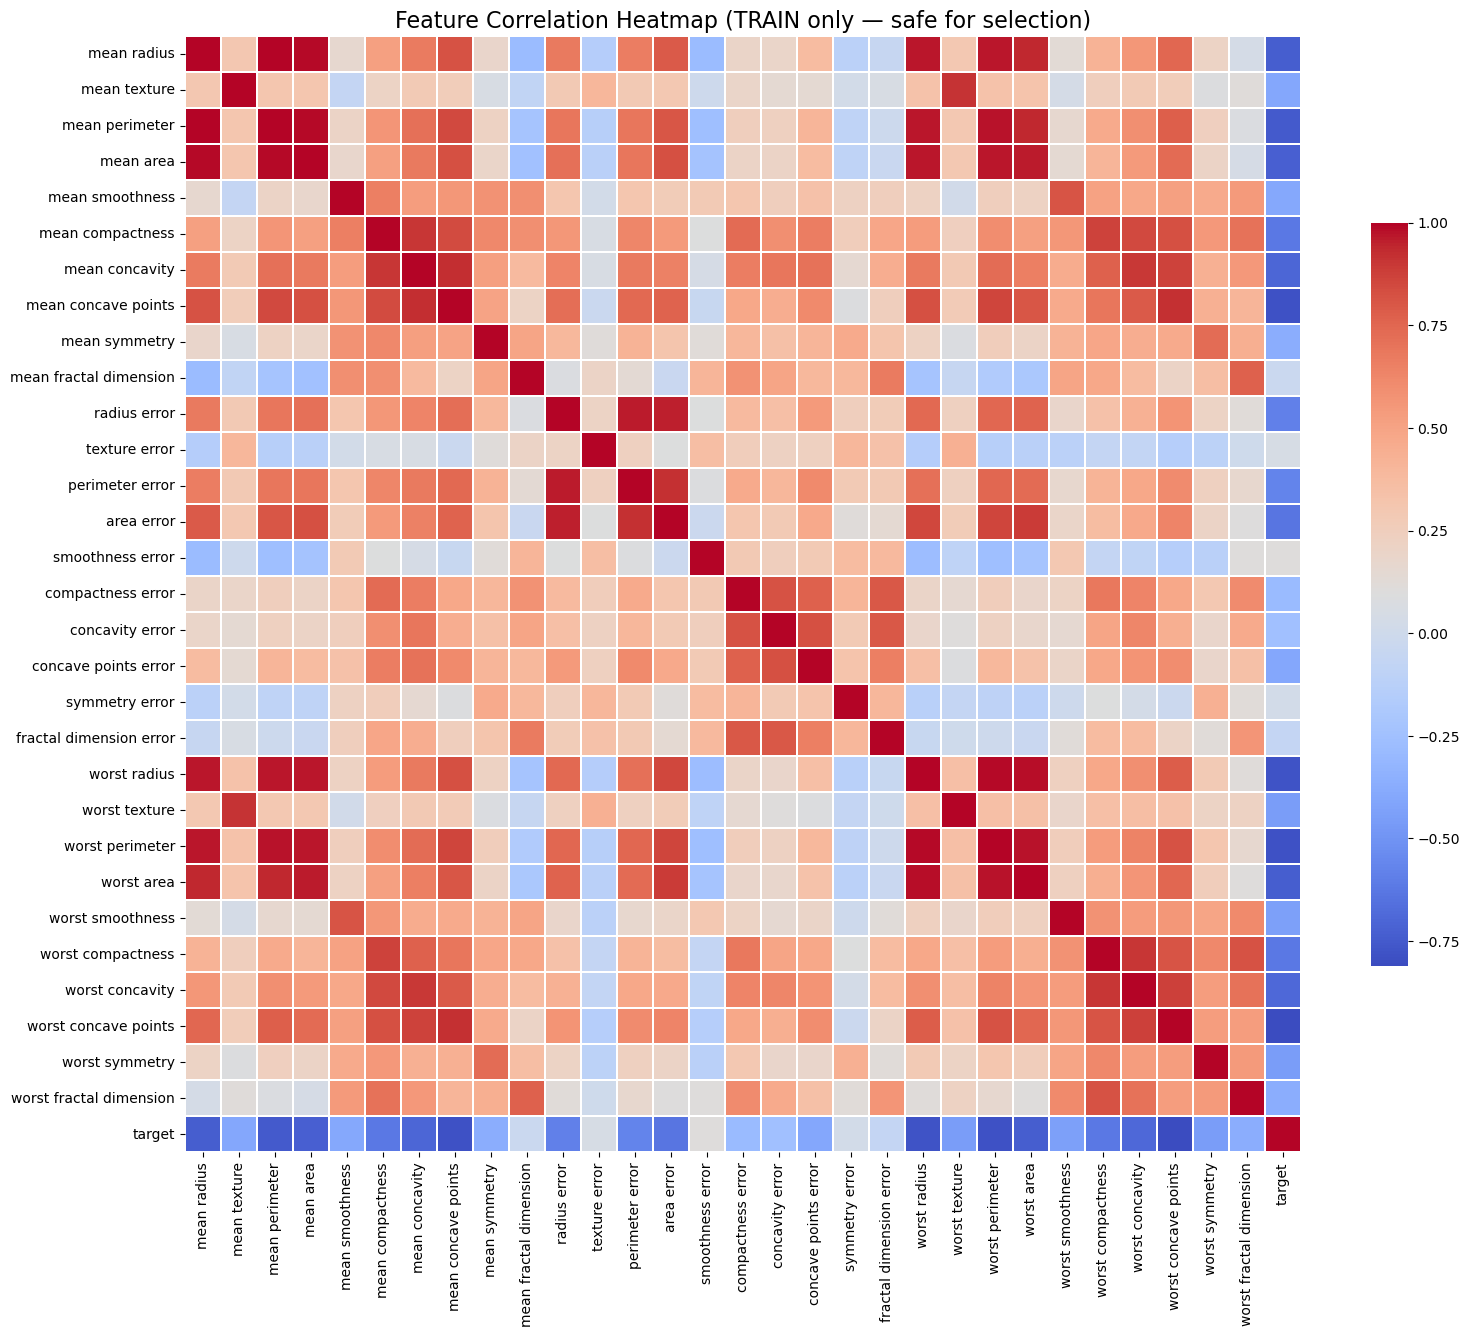

Top 10 by |corr(feature, target)| on TRAIN:
worst concave points    0.810072
mean concave points     0.786946
worst perimeter         0.785392
worst radius            0.778955
mean perimeter          0.752517
worst area              0.738743
mean radius             0.738742
mean area               0.725377
mean concavity          0.697605
worst concavity         0.692148
Name: target, dtype: float64


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# TRAIN-only correlations
df_tr = pd.DataFrame(X_tr, columns=feature_names)
df_tr["target"] = y_tr.astype(int)
corr_tr = df_tr.corr(numeric_only=True)

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_tr,
    cmap="coolwarm",
    annot=False,
    square=True,
    linewidths=0.3,
    cbar_kws={"shrink": 0.6}
)
plt.title("Feature Correlation Heatmap (TRAIN only — safe for selection)", fontsize=16)
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

#  Rank by |corr| on TRAIN
rank_abs = corr_tr["target"].drop("target").abs().sort_values(ascending=False)
topk = rank_abs.head(10).index.tolist()
print("Top 10 by |corr(feature, target)| on TRAIN:")
print(rank_abs.head(10))


In [19]:
# Greedy de-correlation among top-k (TRAIN only)
sub_abs = corr_tr.loc[topk, topk].abs()
keep = []
for f in sub_abs.columns:
    if all(sub_abs.loc[f, g] < 0.95 for g in keep):
        keep.append(f)
print("Selected (de-correlated):", keep)

# Build candidate PAIRS with redundancy filter (TRAIN only)
def build_pairs(feats, max_abs_r=0.85):
    out = []
    for a, b in itertools.combinations(feats, 2):
        if abs(corr_tr.loc[a, b]) < max_abs_r:
            out.append((a, b))
    return out

pairs = build_pairs(keep, max_abs_r=0.85)
if len(pairs) == 0:
    # fallback: relax the threshold or use topk
    pairs = build_pairs(topk, max_abs_r=0.90)
print(f"Candidate pairs: {len(pairs)}")
print(pairs[:10])

Selected (de-correlated): ['worst concave points', 'mean concave points', 'worst perimeter', 'mean concavity', 'worst concavity']
Candidate pairs: 4
[('worst concave points', 'worst perimeter'), ('mean concave points', 'worst concavity'), ('worst perimeter', 'mean concavity'), ('worst perimeter', 'worst concavity')]


## 3. Low redundancy + Validation ranking

- Validation ranking table (AUC → Recall_malignant → Accuracy)

In [20]:

import pandas as pd

# Tiny 2D logistic (reuse)
def train_logreg_2d(X, y, lr=0.01, epochs=200, seed=0):
    rng = np.random.default_rng(seed)
    W = rng.normal(0.0, 0.01, size=(2, 1))
    b = np.zeros((1,), float)
    N = X.shape[0]
    y = y.reshape(-1, 1).astype(float)
    for _ in range(epochs):
        z = X @ W + b
        yhat = 1.0 / (1.0 + np.exp(-z))
        dz = (yhat - y) / N
        W -= (X.T @ dz) * lr
        b -= dz.sum(axis=0) * lr
    return W, b

def eval_pair(feat1, feat2):
    i, j = feature_names.index(feat1), feature_names.index(feat2)

    # Train on inner TRAIN fold
    W, b = train_logreg_2d(X_tr[:, [i, j]], y_tr, lr=0.01, epochs=200, seed=0)

    # Validate on inner VAL fold
    probs_val = 1.0 / (1.0 + np.exp(-(X_val[:, [i, j]] @ W + b)))
    preds_val = (probs_val >= 0.5).astype(int)

    # Metrics (detailed names)
    Accuracy         = accuracy_score(y_val, preds_val)
    Recall_benign    = recall_score(y_val, preds_val, pos_label=1)
    Recall_malignant = recall_score(y_val, preds_val, pos_label=0)
    Precision_benign = precision_score(y_val, preds_val, pos_label=1)
    F1_benign        = f1_score(y_val, preds_val, pos_label=1)
    AUC              = roc_auc_score(y_val, probs_val)
    CM               = confusion_matrix(y_val, preds_val)

    return {
        "pair": (feat1, feat2), "idx": (i, j),
        "AUC": AUC, "Accuracy": Accuracy,
        "Recall_malignant": Recall_malignant,
        "Recall_benign": Recall_benign,
        "Precision_benign": Precision_benign,
        "F1_benign": F1_benign,
        "Confusion_matrix": CM
    }

# Build and rank
val_rows = [eval_pair(a, b) for (a, b) in pairs]
val_rows = sorted(val_rows,
                  key=lambda r: (r["AUC"], r["Recall_malignant"], r["Accuracy"]),
                  reverse=True)

val_df = pd.DataFrame([{
    "Feature_1": r["pair"][0],
    "Feature_2": r["pair"][1],
    "AUC": r["AUC"],
    "Accuracy": r["Accuracy"],
    "Recall_malignant": r["Recall_malignant"],
    "Recall_benign": r["Recall_benign"],
    "Precision_benign": r["Precision_benign"],
    "F1_benign": r["F1_benign"],
} for r in val_rows])

print("Validation ranking (top 6):")
print(val_df.head(6))

# Save best and top-3 for the next cell
best = val_rows[0]
top3_pairs = [r["pair"] for r in val_rows[:3]]
print("Top-3 pairs:", top3_pairs)



Validation ranking (top 6):
              Feature_1        Feature_2       AUC  Accuracy  \
0       worst perimeter   mean concavity  0.965944  0.956044   
1  worst concave points  worst perimeter  0.965944  0.934066   
2       worst perimeter  worst concavity  0.957688  0.945055   
3   mean concave points  worst concavity  0.936533  0.901099   

   Recall_malignant  Recall_benign  Precision_benign  F1_benign  
0          0.911765       0.982456          0.949153   0.965517  
1          0.911765       0.947368          0.947368   0.947368  
2          0.941176       0.947368          0.964286   0.955752  
3          0.823529       0.947368          0.900000   0.923077  
Top-3 pairs: [('worst perimeter', 'mean concavity'), ('worst concave points', 'worst perimeter'), ('worst perimeter', 'worst concavity')]


## Top-3 comparison on TEST (metrics + decision-boundary plots)


TEST — Pair: worst perimeter + mean concavity
✅ Accuracy:  0.947
🎯 Recall (Benign=1):    0.986
🎯 Recall (Malignant=0): 0.881
🎯 Precision (Benign=1): 0.934
💡 F1 (Benign=1):        0.959
📈 AUC:       0.987
🧾 Confusion Matrix:
 [[37  5]
 [ 1 71]]


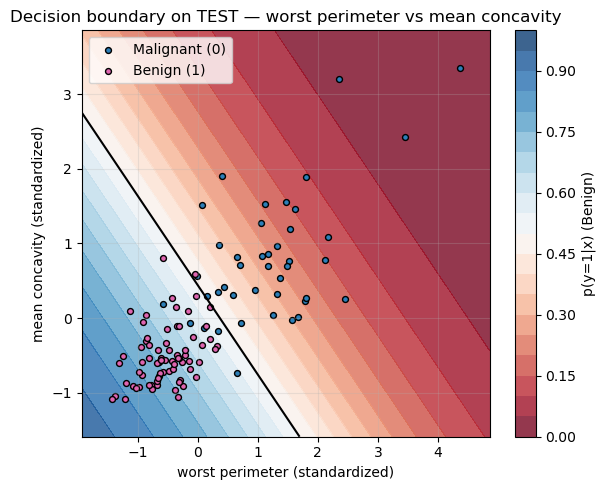


TEST — Pair: worst concave points + worst perimeter
✅ Accuracy:  0.939
🎯 Recall (Benign=1):    0.944
🎯 Recall (Malignant=0): 0.929
🎯 Precision (Benign=1): 0.958
💡 F1 (Benign=1):        0.951
📈 AUC:       0.987
🧾 Confusion Matrix:
 [[39  3]
 [ 4 68]]


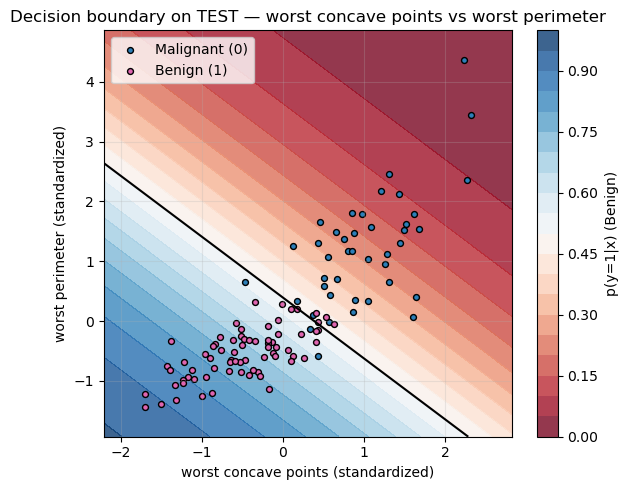


TEST — Pair: worst perimeter + worst concavity
✅ Accuracy:  0.921
🎯 Recall (Benign=1):    0.944
🎯 Recall (Malignant=0): 0.881
🎯 Precision (Benign=1): 0.932
💡 F1 (Benign=1):        0.938
📈 AUC:       0.977
🧾 Confusion Matrix:
 [[37  5]
 [ 4 68]]


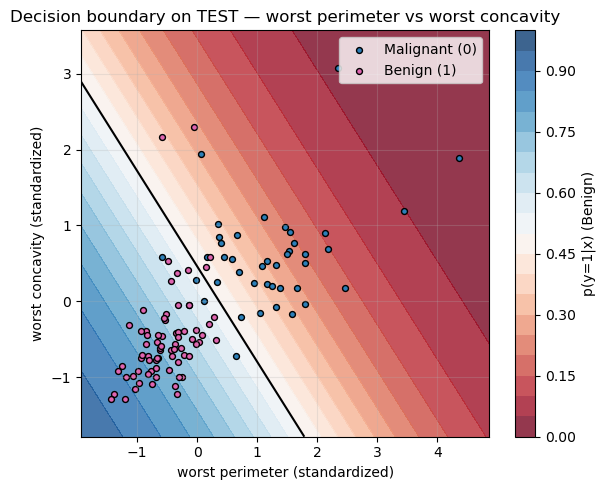

In [21]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np



def predict_proba(X, W, b):
    return 1.0 / (1.0 + np.exp(-(X @ W + b)))

def pretty_report(tag, y_true, y_prob):
    y_pred = (y_prob >= 0.5).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    auc  = roc_auc_score(y_true, y_prob)
    rec1 = recall_score(y_true, y_pred, pos_label=1)
    rec0 = recall_score(y_true, y_pred, pos_label=0)
    prec = precision_score(y_true, y_pred, pos_label=1)
    f1   = f1_score(y_true, y_pred, pos_label=1)
    cm   = confusion_matrix(y_true, y_pred)
    print(f"\n{tag}")
    print(f"✅ Accuracy:  {acc:.3f}")
    print(f"🎯 Recall (Benign=1):    {rec1:.3f}")
    print(f"🎯 Recall (Malignant=0): {rec0:.3f}")
    print(f"🎯 Precision (Benign=1): {prec:.3f}")
    print(f"💡 F1 (Benign=1):        {f1:.3f}")
    print(f"📈 AUC:       {auc:.3f}")
    print("🧾 Confusion Matrix:\n", cm)

def plot_boundary_2d(feat1, feat2, W, b, X2, y, title):
    x1, x2 = X2[:, 0], X2[:, 1]
    m = 0.5
    x1_min, x1_max = x1.min()-m, x1.max()+m
    x2_min, x2_max = x2.min()-m, x2.max()+m
    xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 300),
                         np.linspace(x2_min, x2_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = predict_proba(grid, W, b).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    cs = plt.contourf(xx, yy, Z, levels=np.linspace(0,1,21), cmap="RdBu", alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0.5], colors="k", linewidths=1.5)
    plt.colorbar(cs, label="p(y=1|x) (Benign)")
    plt.scatter(X2[y.ravel()==0,0], X2[y.ravel()==0,1], s=18, c="#2c7fb8", edgecolor="k", label="Malignant (0)")
    plt.scatter(X2[y.ravel()==1,0], X2[y.ravel()==1,1], s=18, c="#df65b0", edgecolor="k", label="Benign (1)")
    plt.xlabel(f"{feat1} (standardized)"); plt.ylabel(f"{feat2} (standardized)")
    plt.title(title); plt.legend(); plt.grid(True, alpha=0.25); plt.tight_layout(); plt.show()

# Iterate the top-3 pairs
results = []
for (f1, f2) in top3_pairs:
    i, j = feature_names.index(f1), feature_names.index(f2)

    # Train on full TRAIN set (std)
    W, b = train_logreg_2d(X_train[:, [i, j]], y_train, lr=0.01, epochs=300, seed=0)

    # Test metrics
    probs_te = predict_proba(X_test[:, [i, j]], W, b)
    pretty_report(f"TEST — Pair: {f1} + {f2}", y_test.ravel(), probs_te)

    # Boundary plot (TEST)
    plot_boundary_2d(f1, f2, W, b, X_test[:, [i, j]], y_test,
                     f"Decision boundary on TEST — {f1} vs {f2}")

### Best pair to choose (per our results + rule AUC → malignant recall → accuracy):

#### → worst concave points + worst perimeter

it matches the top AUC (0.987) but achieves the highest malignant recall (0.929), which matters most for not missing cancers. Accuracy (0.939) is only slightly below the alternative (0.947), and the features are complementary—shape/irregularity + size/extent—which is exactly what your train-only EDA suggested.